![](https://media.discordapp.net/attachments/1047111061314220033/1176542563633737728/image.png)


_Notes :_

- Approche contre factuelle $\Rightarrow$ que faire pour que l'exemple ne soit plus un outlier ?
- Base de référence : dataset classique


# TME 8 - Détection et explication d'exceptions


## Génération d'une base artificielle


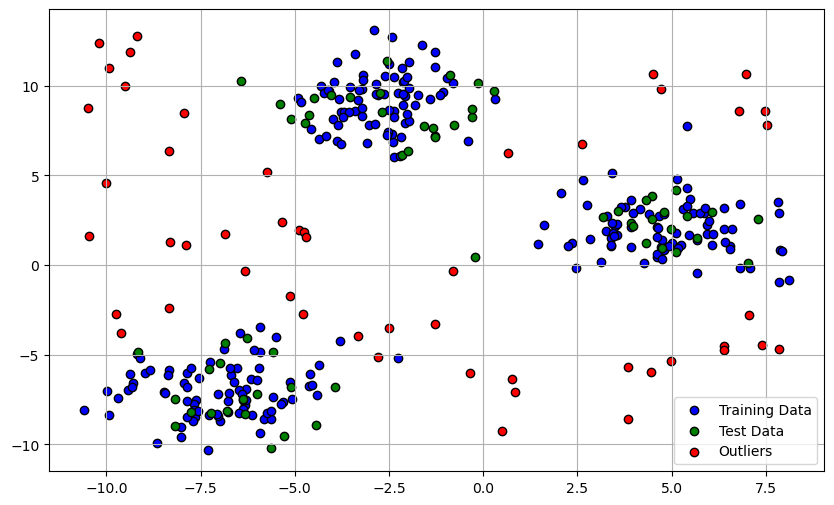

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


def generate_blobs(
    n_samples=500,
    n_clusters=3,
    cluster_std=1.0,
    n_outliers=50,
    random_seed=42,
):
    """Génère des données artificielles de type "blobs".

    :param n_samples: Nombre d'échantillons, 500 par défaut.
    :param n_clusters: Nombre de clusters, 3 par défaut.
    :param cluster_std: Ecart-type des clusters, 1.0 par défaut.
    :param n_outliers: Nombre d'outliers, 50 par défaut.
    :param random_seed: Graine aléatoire, 42 par défaut.
    :return: Un ensemble de train, de test et d'outliers.
    """
    rng = np.random.RandomState(random_seed)

    X, _, centers = make_blobs(
        n_samples=n_samples,
        n_features=2,
        centers=n_clusters,
        cluster_std=cluster_std,
        random_state=random_seed,
        return_centers=True,
    )

    X_outliers = generate_outliers(
        X, centers, n_outliers=n_outliers, random_seed=random_seed
    )

    # Séparer les données en ensembles d'entraînement et de test
    rng.shuffle(X)
    n_train = int(0.8 * len(X))
    X_train = X[:n_train]
    X_test = X[n_train:]

    return X_train, X_test, X_outliers


def generate_outliers(X, centers, n_outliers=50, min_distance=4, random_seed=42):
    """Génère des outliers, c'est-à-dire des points qui sont en dehors des clusters
    générés. Le plus simple serait de générer aléatoirement des outliers sur l'ensemble
    de la grille, mais cela résulterait en des outliers faisant potentiellement partie
    de clusters, biaisant alors notre détection.

    :param X: Clusters.
    :param centers: Centres des clusters.
    :param n_outliers: Nombre d'outliers, defaults to 50
    :param min_distance: Distance euclidienneminimale entre les clusters et les outliers,
    4 est une bonne valeur minimisant le nombre d'outliers pouvant apparaître dans les
    clusters tout en leur laissant la possibilité d'être proche.
    :param random_seed: Graine aléatoire pour la reproductibilité.
    :return: Un ensemble d'outliers.
    """
    rng = np.random.RandomState(random_seed)
    # Générer des outliers
    X_outliers = []
    while len(X_outliers) < n_outliers:
        outlier_candidate = rng.uniform(X.min(axis=0), X.max(axis=0), X.shape[1])
        # Est-ce que le candidat est un outlier, c.-à-d. ne fait-il pas partie d'un cluster ?
        if np.all(
            np.min(np.linalg.norm(centers - outlier_candidate, axis=1)) >= min_distance
        ):
            X_outliers.append(outlier_candidate)
    return np.array(X_outliers)


def plot_data(X_train, X_test, X_outliers):
    """Affiche les données artificiellement générées."""
    plt.figure(figsize=(10, 6))
    # Plot les données d'entraînement
    plt.scatter(
        X_train[:, 0], X_train[:, 1], c="blue", label="Training Data", edgecolors="k"
    )
    # Plot les données de test
    plt.scatter(
        X_test[:, 0], X_test[:, 1], c="green", label="Test Data", edgecolors="k"
    )
    # Plot les outliers
    plt.scatter(
        X_outliers[:, 0], X_outliers[:, 1], c="red", label="Outliers", edgecolors="k"
    )
    plt.legend()
    plt.grid(True)
    plt.show()


X_train, X_test, X_outliers = generate_blobs(
    n_samples=300, n_clusters=3, cluster_std=1.5, n_outliers=50
)
plot_data(X_train, X_test, X_outliers)

## Détection d'exceptions

Avec Scikit-learn, il existe deux méthodes possibles :

- **Outlier detection** : approche supervisée, les données contiennent les outliers.
- **Novelty detection** : approche non supervisée, les données ne contiennent pas les outliers.

La différence majeure concerne le LOF, qui a été désigné spécifiquement pour de l'outlier detection. Dans ce mode de détection, LOF ne contient qu'une méthode `fit_predict` : il est **impossible** d'obtenir les frontières de décision. On peut seulement obtenir les scores : plus le score est grand, plus l'observation est un outlier.

Pour le One-Class SVM et la forêt d'isolation, la construction du classifieur ne change pas.


In [2]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest


def train_lof(X_train, mode, n_neighbors=20, contamination="auto"):
    """Entraine un Local Outlier Factor.

    Outlier detection si mode=False, novelty detection si mode=True.
    """
    clf = LocalOutlierFactor(
        n_neighbors=n_neighbors, novelty=mode, contamination=contamination
    )
    if mode:
        clf.fit(X_train)
    return clf


def train_one_class_svm(X_train, nu=0.5, gamma="auto"):
    """Entraine un One-Class SVM."""
    clf = OneClassSVM(kernel="rbf", gamma=gamma, nu=nu)
    clf.fit(X_train)
    return clf


def train_isolation_forest(
    X_train, n_estimators=100, contamination="auto", random_state=0
):
    """Entraine une forêt d'isolation."""
    clf = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=random_state,
    )
    clf.fit(X_train)
    return clf

### Outlier detection


In [3]:
from matplotlib.legend_handler import HandlerPathCollection


def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


def plot_decision_boundary_outlier(clf, X, X_outliers, ax=None, title=None):
    """Affiche les frontières de décision pour OneClassSVM, IsolationForest, le score
    des outliers pour LOF.
    """
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Create grid to plot decision boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    mesh_samples = np.c_[xx.ravel(), yy.ravel()]

    if clf.__class__.__name__ == "LocalOutlierFactor":
        y_pred = clf.fit_predict(X)
        Z = clf.negative_outlier_factor_
        radius = (Z.max() - Z) / (Z.max() - Z.min())
        scatter = ax.scatter(
            X[:, 0],
            X[:, 1],
            s=1000 * radius,
            edgecolor="firebrick",
            facecolors="none",
            label="Outliers scores",
        )
    else:
        y_pred = clf.predict(X)
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(mesh_samples)
        else:
            Z = clf.predict(mesh_samples)

        Z = Z.reshape(xx.shape)
        contour = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
        cbar = plt.colorbar(contour, ax=ax)
        cbar.set_label("Decision Function Value")

    # Plot training points
    ax.scatter(X[:, 0], X[:, 1], c="blueviolet", edgecolor="k", s=20, label="Obs.")

    # Plot outliers
    ax.scatter(
        X_outliers[:, 0],
        X_outliers[:, 1],
        c="r",
        edgecolor="k",
        s=20,
        label="Outlier",
    )

    if title:
        ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    if clf.__class__.__name__ == "LocalOutlierFactor":
        ax.legend(
            fontsize="small",
            handler_map={
                scatter: HandlerPathCollection(update_func=update_legend_marker_size)
            },
        )
    else:
        ax.legend(fontsize="small")

    # Statistics
    ground_truth = np.ones(len(X), dtype=int)
    ground_truth[-len(X_outliers) :] = -1
    n_errors = (y_pred != ground_truth).sum()
    ax.set_xlabel(f"errors: {n_errors}/{X.shape[0]}")

    return ax

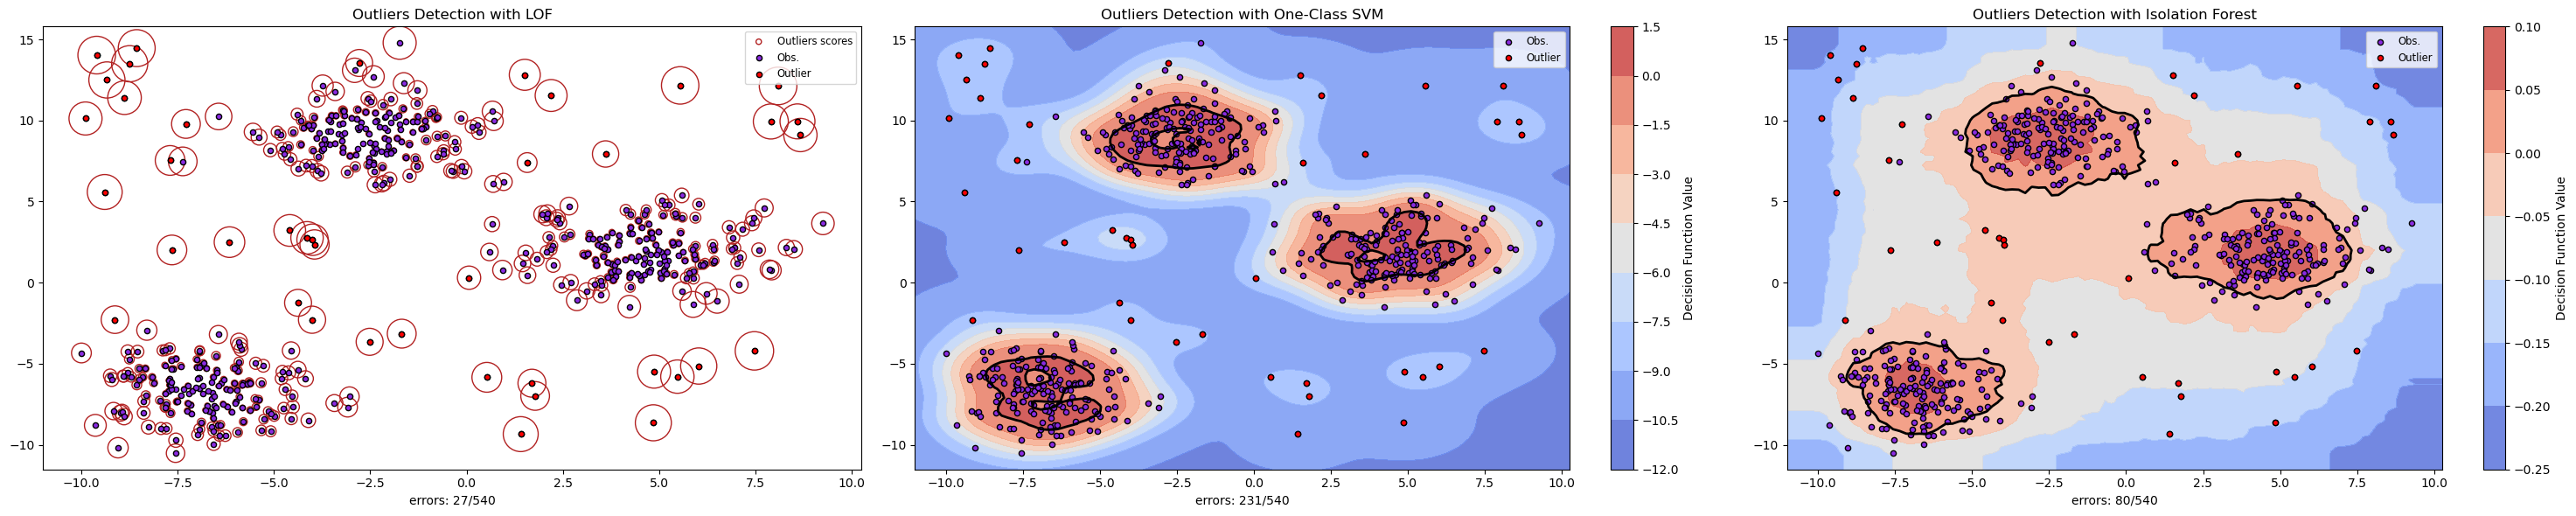

In [4]:
# Generate data
X_train, X_test, X_outliers = generate_blobs(
    n_samples=500, n_clusters=3, cluster_std=1.5, n_outliers=40
)
X = np.vstack((X_train, X_test, X_outliers))
# Entraîner chaque modèle
lof_clf = train_lof(X, mode=False)
svm_clf = train_one_class_svm(X)
iso_forest_clf = train_isolation_forest(X)

# Visualize decision boundaries for each model
fig, ax = plt.subplots(1, 3, figsize=(30, 6))

plot_decision_boundary_outlier(
    lof_clf, X, X_outliers, ax=ax[0], title="Outliers Detection with LOF"
)
plot_decision_boundary_outlier(
    svm_clf, X, X_outliers, ax=ax[1], title="Outliers Detection with One-Class SVM"
)
plot_decision_boundary_outlier(
    iso_forest_clf,
    X,
    X_outliers,
    ax=ax[2],
    title="Outliers Detection with Isolation Forest",
)
fig.tight_layout()

### Novelty detection


In [5]:
def plot_decision_boundary_novelty(
    clf, X_train, X_test, X_outliers, explain=False, ax=None, title=None
):
    """Affiche les frontières de décision d'un classifieur."""
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Create grid to plot decision boundaries
    x_min, x_max = (
        min(X_train[:, 0].min(), X_outliers[:, 0].min()) - 1,
        max(X_train[:, 0].max(), X_outliers[:, 0].max()) + 1,
    )
    y_min, y_max = (
        min(X_train[:, 1].min(), X_outliers[:, 1].min()) - 1,
        max(X_train[:, 1].max(), X_outliers[:, 1].max()) + 1,
    )
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    mesh_samples = np.c_[xx.ravel(), yy.ravel()]

    # Plot decision boundary
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(mesh_samples)
    else:
        Z = clf.predict(mesh_samples)
    Z = Z.reshape(xx.shape)
    contour = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
    # Add a colorbar
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label("Decision Function Value")

    # Plot training points
    ax.scatter(
        X_train[:, 0],
        X_train[:, 1],
        c="white",
        edgecolor="k",
        s=20,
        label="Training obs.",
    )

    if explain:
        color = "white"
        label = None
    else:
        color = "blueviolet"
        label = "New regular obs."
    # Plot test points
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=color,
        edgecolor="k",
        s=20,
        label=label,
    )
    # Plot outliers
    ax.scatter(
        X_outliers[:, 0],
        X_outliers[:, 1],
        c="red",
        edgecolor="k",
        s=20,
        label="New abnormal obs.",
    )

    if title:
        ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend(fontsize="small")

    # Statistics
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers = clf.predict(X_outliers)
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size
    n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
    ax.set_xlabel(
        "error train: %d/%d; errors novel regular: %d/%d; errors novel abnormal: %d/%d"
        % (
            n_error_train,
            X_train.shape[0],
            n_error_test,
            X_test.shape[0],
            n_error_outliers,
            X_outliers.shape[0],
        )
    )

    return ax

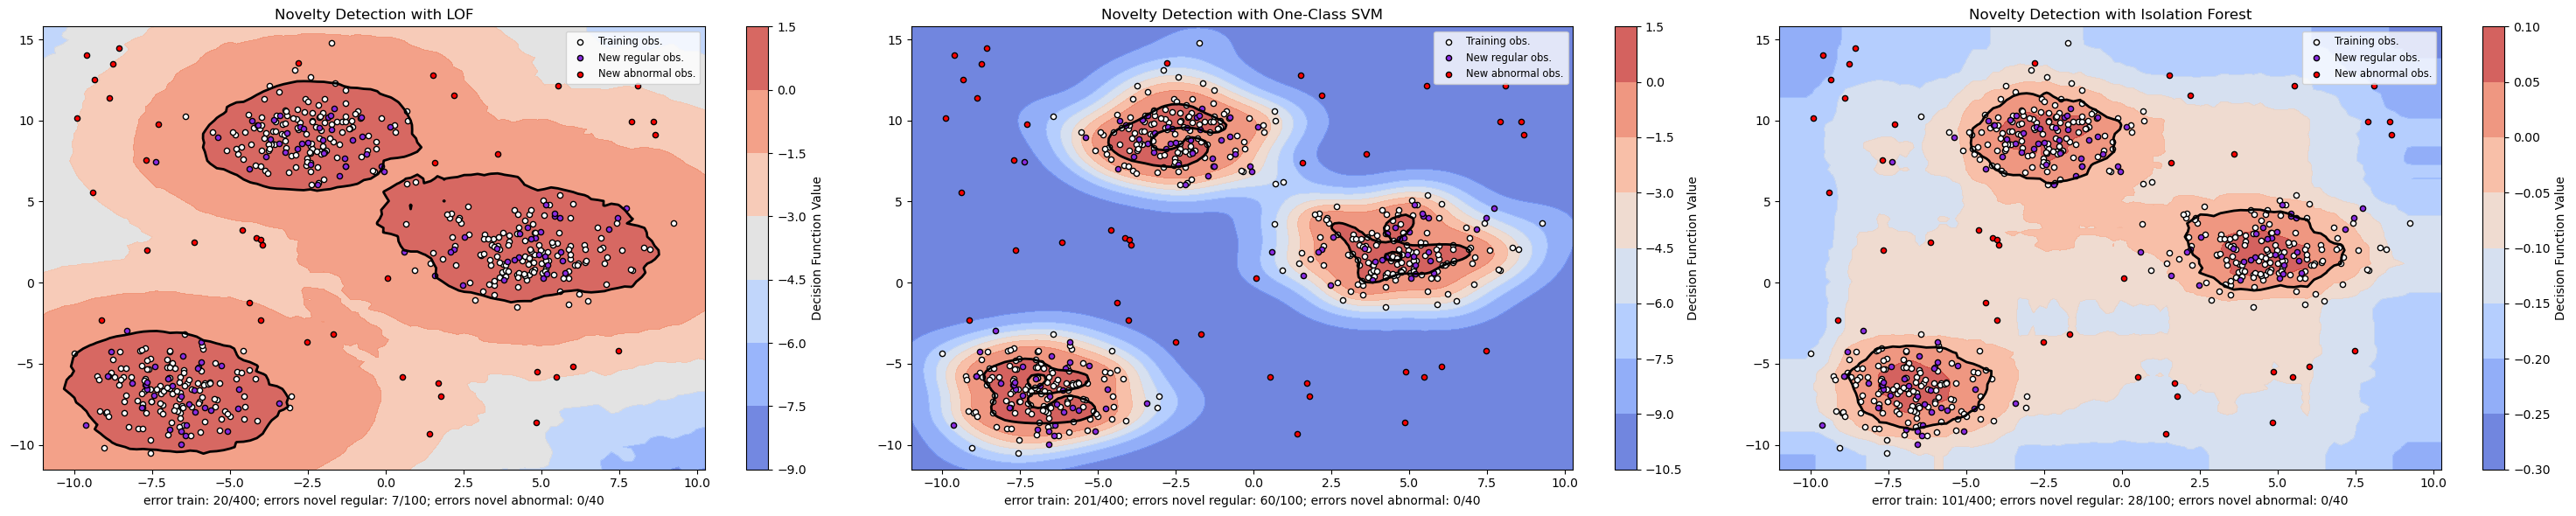

In [6]:
# Generate data
X_train, X_test, X_outliers = generate_blobs(
    n_samples=500, n_clusters=3, cluster_std=1.5, n_outliers=40
)

# Entraîner chaque modèle
lof_clf = train_lof(X_train, mode=True)
svm_clf = train_one_class_svm(X_train)
iso_forest_clf = train_isolation_forest(X_train)

# Visualize decision boundaries for each model
fig, ax = plt.subplots(1, 3, figsize=(30, 6))

plot_decision_boundary_novelty(
    lof_clf, X_train, X_test, X_outliers, ax=ax[0], title="Novelty Detection with LOF"
)
plot_decision_boundary_novelty(
    svm_clf,
    X_train,
    X_test,
    X_outliers,
    ax=ax[1],
    title="Novelty Detection with One-Class SVM",
)
plot_decision_boundary_novelty(
    iso_forest_clf,
    X_train,
    X_test,
    X_outliers,
    ax=ax[2],
    title="Novelty Detection with Isolation Forest",
)
fig.tight_layout()

J'aimerais bien avoir des données plus "allongées", comme dans le cours.

$\Rightarrow$ Loi normale multidimensionnelle : $\mathcal{N}(\mu, \Sigma)$ où $\mu \in \mathbb{R}^N$ représente le centre et $\Sigma \in \mathcal{M}_N(\mathbb{R})$ est sa matrice de covariance, $N$ étant la dimension de nos données (2 car nous travaillons en 2D).


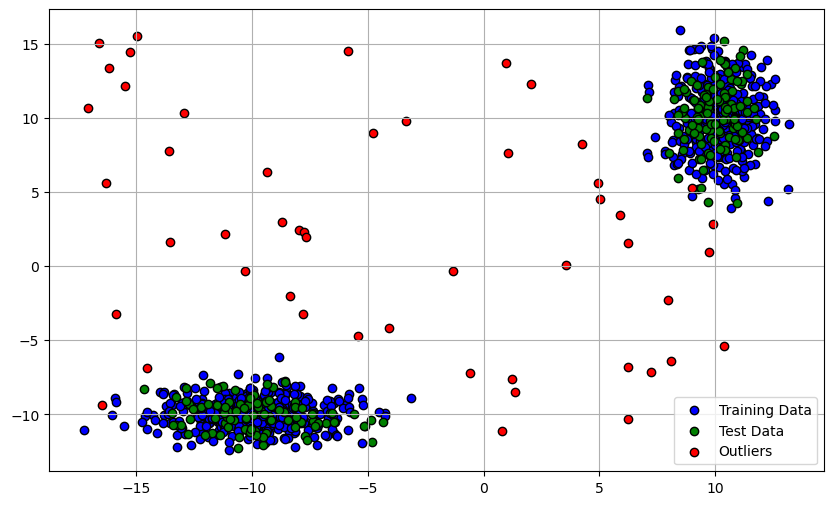

In [7]:
def generate_elongated(
    n_samples=1000,
    n_clusters=2,
    centers=[(-10, -10), (10, 10)],
    cov=[np.array([[5, 0], [0, 1]]), np.array([[1, 0], [0, 5]])],
    n_outliers=50,
    random_seed=42,
):
    """Génère des données artificielles "allongées", c.à-d. des distributions
    normales multidimensionnelles.

    :param n_samples: Nombre d'échantillons, 1000 par défaut.
    :param n_clusters: Nombre de clusters, 2 par défaut.
    :param centers: Les centres pour chaque cluster.
    :param cov: Les matrices de covariance pour chaque cluster.
    :param n_outliers: Nombre d'outliers, 50 par défaut.
    :param random_seed: Graine aléatoire, 42 par défaut.
    :return: Un ensemble de train, de test et d'outliers.
    """
    assert len(centers) == n_clusters, ValueError(
        f"Number of centers {len(centers)} must match number of clusters {n_clusters}"
    )
    assert len(cov) == n_clusters, ValueError(
        f"Number of covariance matrixes {len(centers)} must match number of clusters {n_clusters}"
    )

    rng = np.random.RandomState(random_seed)

    # Génération de distributions normales multidimensionnelles
    X = np.empty((0, 2))

    for cluster in range(n_clusters):
        X_cluster = rng.multivariate_normal(
            centers[cluster], cov[cluster], n_samples // n_clusters
        )
        X = np.vstack([X, X_cluster])

    # Générer des outliers
    X_outliers = generate_outliers(
        X, centers, n_outliers=n_outliers, random_seed=random_seed
    )

    # Séparer les données en ensembles d'entraînement et de test
    rng.shuffle(X)
    n_train = int(0.8 * len(X))
    X_train = X[:n_train]
    X_test = X[n_train:]

    return X_train, X_test, X_outliers


X_train, X_test, X_outliers = generate_elongated()
plot_data(X_train, X_test, X_outliers)

<Axes: title={'center': 'Novelty Detection with Isolation Forest'}, xlabel='error train: 224/800; errors novel regular: 56/200; errors novel abnormal: 0/50'>

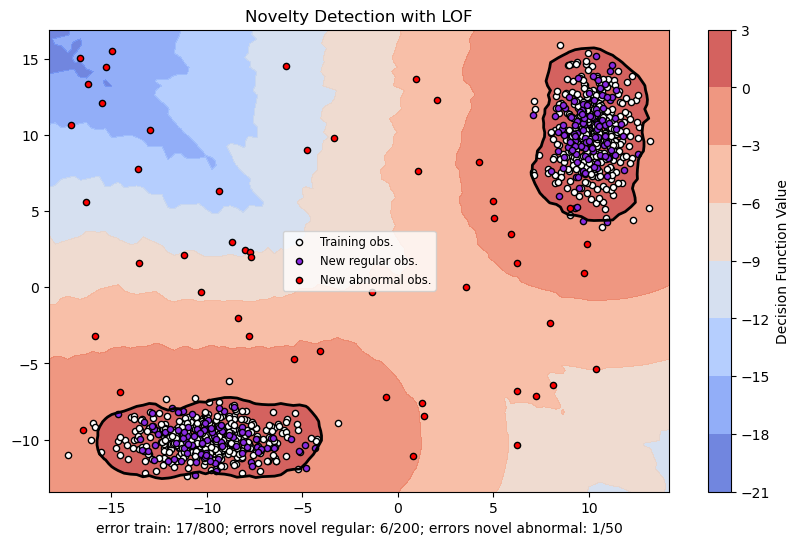

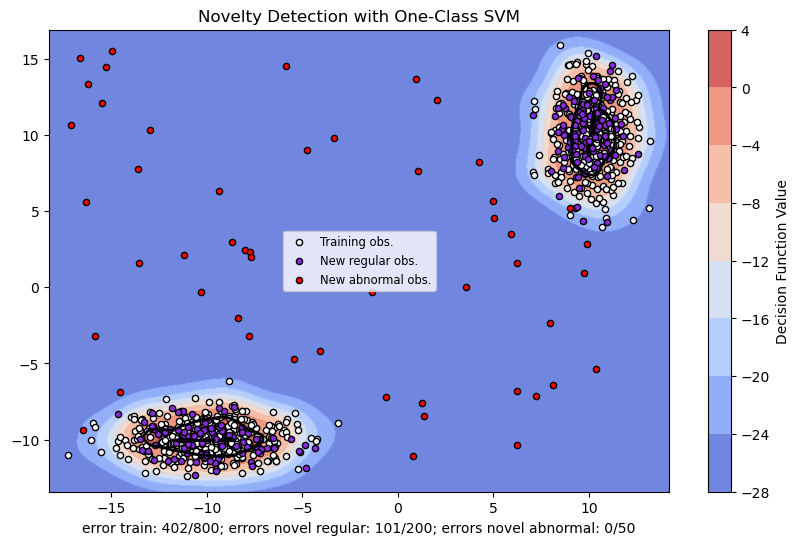

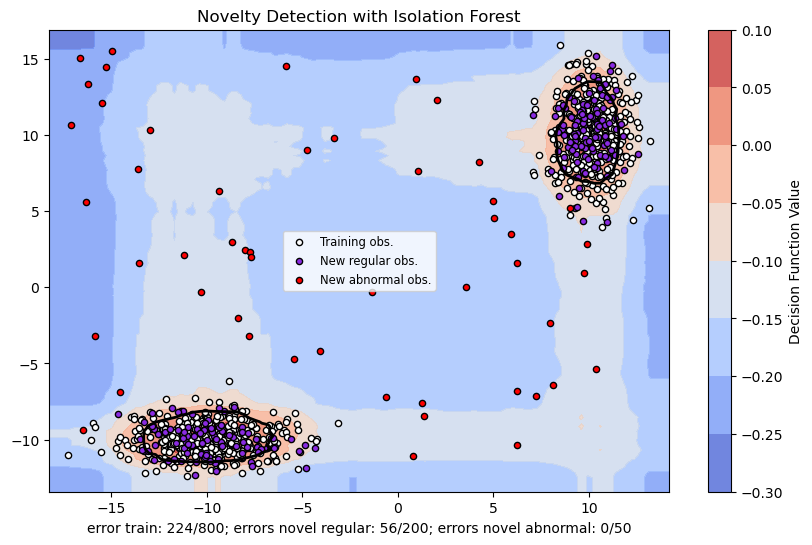

In [8]:
# Entraîner chaque modèle
lof_clf = train_lof(X_train, mode=True)
svm_clf = train_one_class_svm(X_train)
iso_forest_clf = train_isolation_forest(X_train)

# Visualize decision boundaries for each model
plot_decision_boundary_novelty(
    lof_clf, X_train, X_test, X_outliers, title="Novelty Detection with LOF"
)
plot_decision_boundary_novelty(
    svm_clf, X_train, X_test, X_outliers, title="Novelty Detection with One-Class SVM"
)
plot_decision_boundary_novelty(
    iso_forest_clf,
    X_train,
    X_test,
    X_outliers,
    title="Novelty Detection with Isolation Forest",
)

Très content.

$\Rightarrow$ Combiner blobs et distributions normales multidimensionnelles ??


<Axes: xlabel='error train: 383/1200; errors novel regular: 94/300; errors novel abnormal: 0/100'>

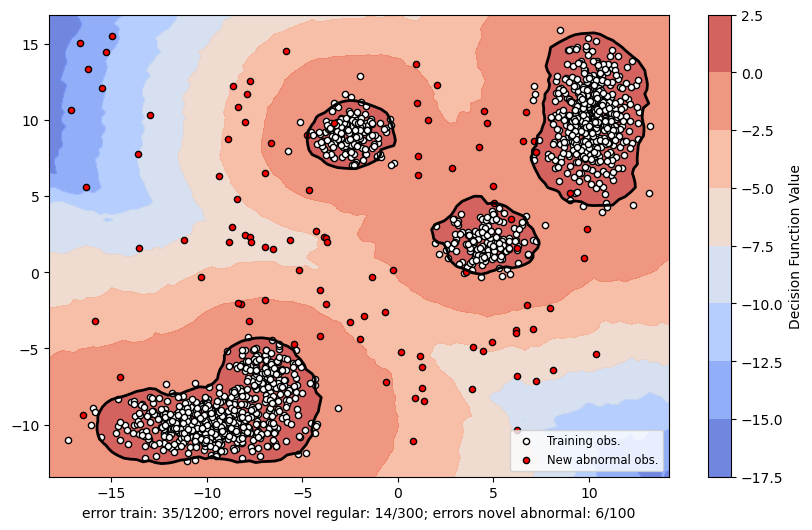

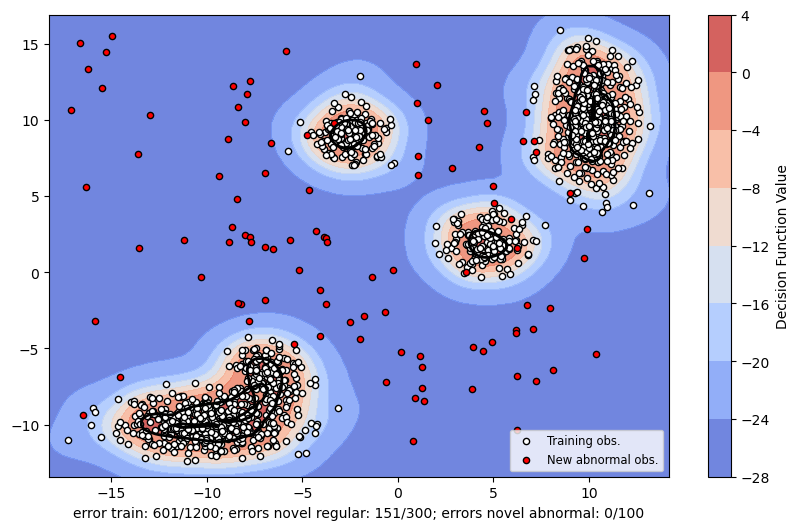

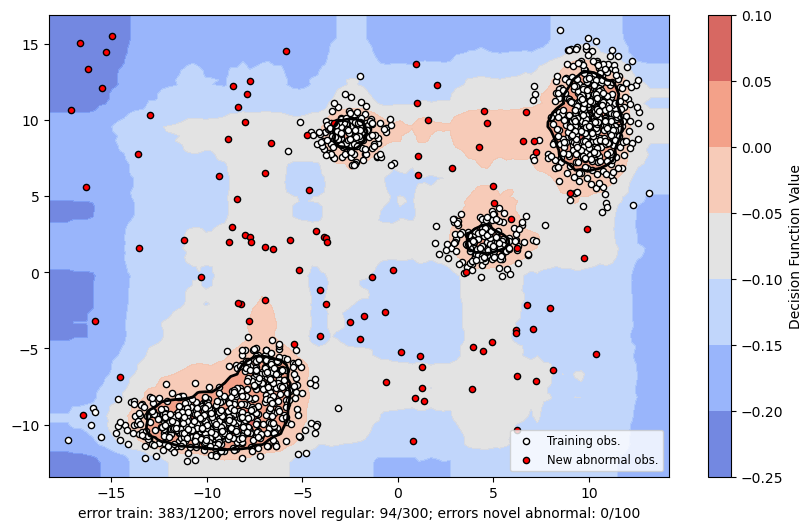

In [9]:
X_blobs_train, X_blobs_test, X_blobs_outliers = generate_blobs()
X_elongated_train, X_elongated_test, X_elongated_outliers = generate_elongated()

X_train = np.vstack((X_blobs_train, X_elongated_train))
X_test = np.vstack((X_blobs_test, X_elongated_test))
X_outliers = np.vstack((X_blobs_outliers, X_elongated_outliers))

# Entraîner chaque modèle
lof_clf = train_lof(X_train, mode=True)
svm_clf = train_one_class_svm(X_train)
iso_forest_clf = train_isolation_forest(X_train)

# Visualize decision boundaries for each model
plot_decision_boundary_novelty(
    lof_clf, X_train, X_test, X_outliers, "Novelty Detection with LOF"
)
plot_decision_boundary_novelty(
    svm_clf, X_train, X_test, X_outliers, "Novelty Detection with One-Class SVM"
)
plot_decision_boundary_novelty(
    iso_forest_clf,
    X_train,
    X_test,
    X_outliers,
    "Novelty Detection with Isolation Forest",
)

Bref, ça marche bien, on peut générer des données plus ou moins complexes maintenant. :)

Néanmois, toutes ces expérimentaitons sur nos différents types de données artificielles nous renvoient des _insights_ intéressants :

- **LOF :** Les frontières de décision est **ajustée autour du noyau des clusters**, qui est caractéristique du LOF (sensible à la densité locale des points de données). Il identifie les valeurs aberrantes comme des points dont la densité est nettement inférieure à celle de leurs voisins. LOF est assez précis dans l'identification des régions denses des données, mais il peut avoir des difficultés avec les points de données qui se trouvent dans les régions peu denses entre les clusters. Néanmoins, c'est **celui qui performe le mieux**.

- **One-Class SVM :** Les frontières de décision sont plus lisses (car noyau RBF) et englobent les clusters. Ce modèle tend à créer une frontière qui tente de conserver les points de données normaux tout en excluant les valeurs aberrantes. Le graphique montre une frontière **étroite autour des clusters**, mais aussi plusieurs petites limites circulaires. On observe une augmentation notable du nombre d'erreurs, tant pour les observations régulières d'entraînement que pour les nouvelles observations, ce qui signifie que la limite est trop restrictive. C'est **celui qui performe le moins**.

- **Forêt d'isolation :** Les frontières de décision sont **irrégulières**, caractéristique des arbres de décision qui cherche à isoler les exceptions. Le graphique suggère que la forêt d'isolation est moins influencée par la distribution sous-jacente des données que par leur structure. Elle effectue un partitionnement qui peut aboutir à des régions de valeurs aberrantes plus grandes, ce qui peut être bénéfique pour les ensembles de données présentant des structures complexes.


### Importance des hyper-paramètres pour le One-Class SVM

Le One-Class SVM semble très sensible aux hyper-paramètres :


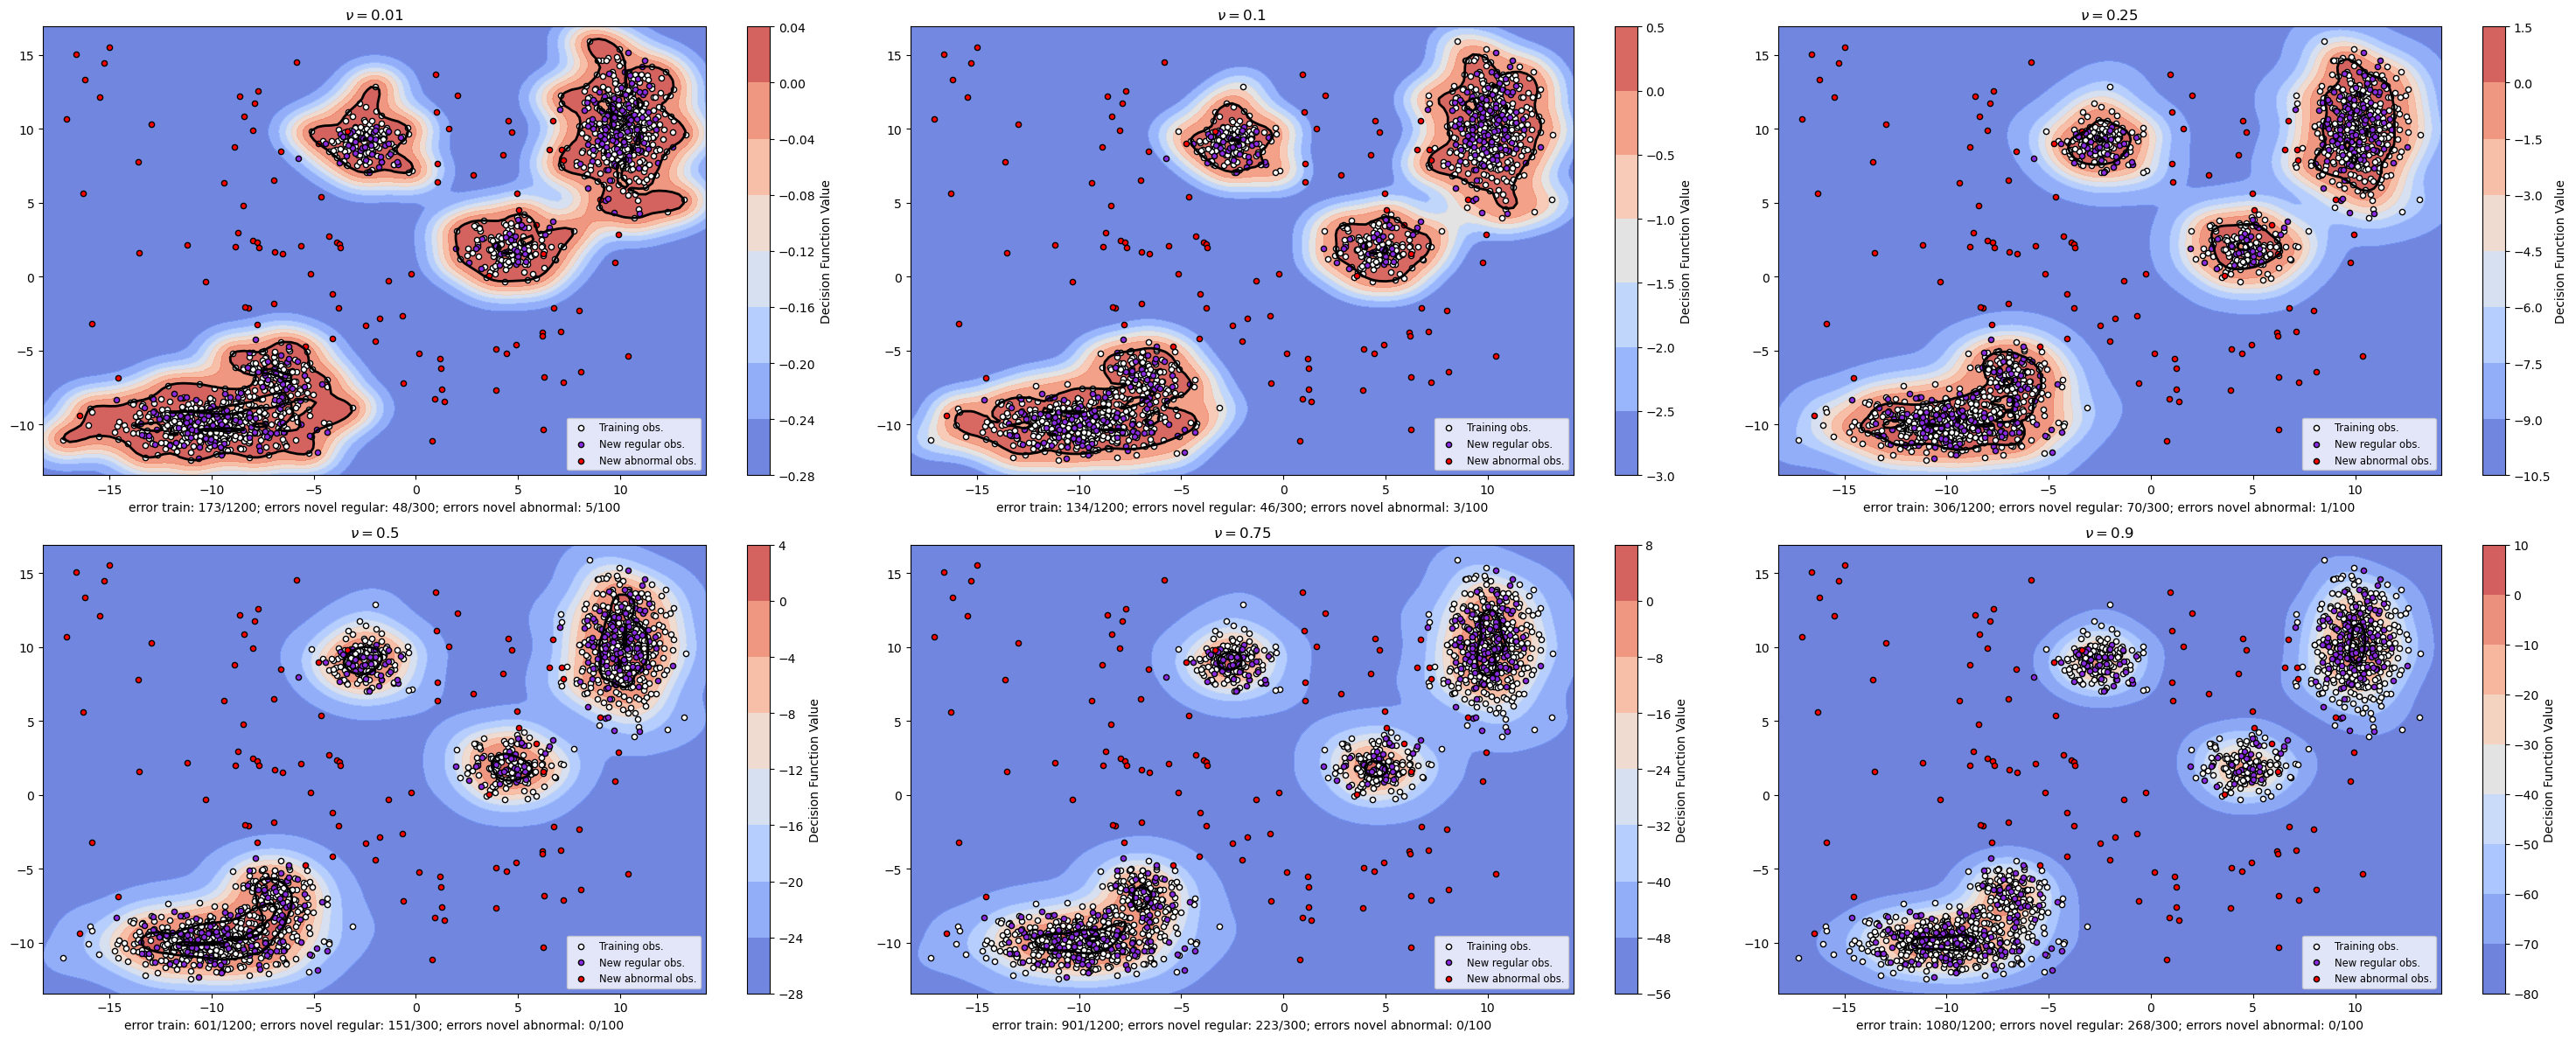

In [10]:
# Visualize decision boundaries for each model
fig, ax = plt.subplots(2, 3, figsize=(30, 12))
ax = ax.flatten()

for i, nu in enumerate([0.01, 0.1, 0.25, 0.5, 0.75, 0.9]):
    svm_clf = train_one_class_svm(X_train, nu=nu)
    plot_decision_boundary_novelty(
        svm_clf, X_train, X_test, X_outliers, ax=ax[i], title=f"$\\nu={nu}$"
    )
fig.tight_layout()

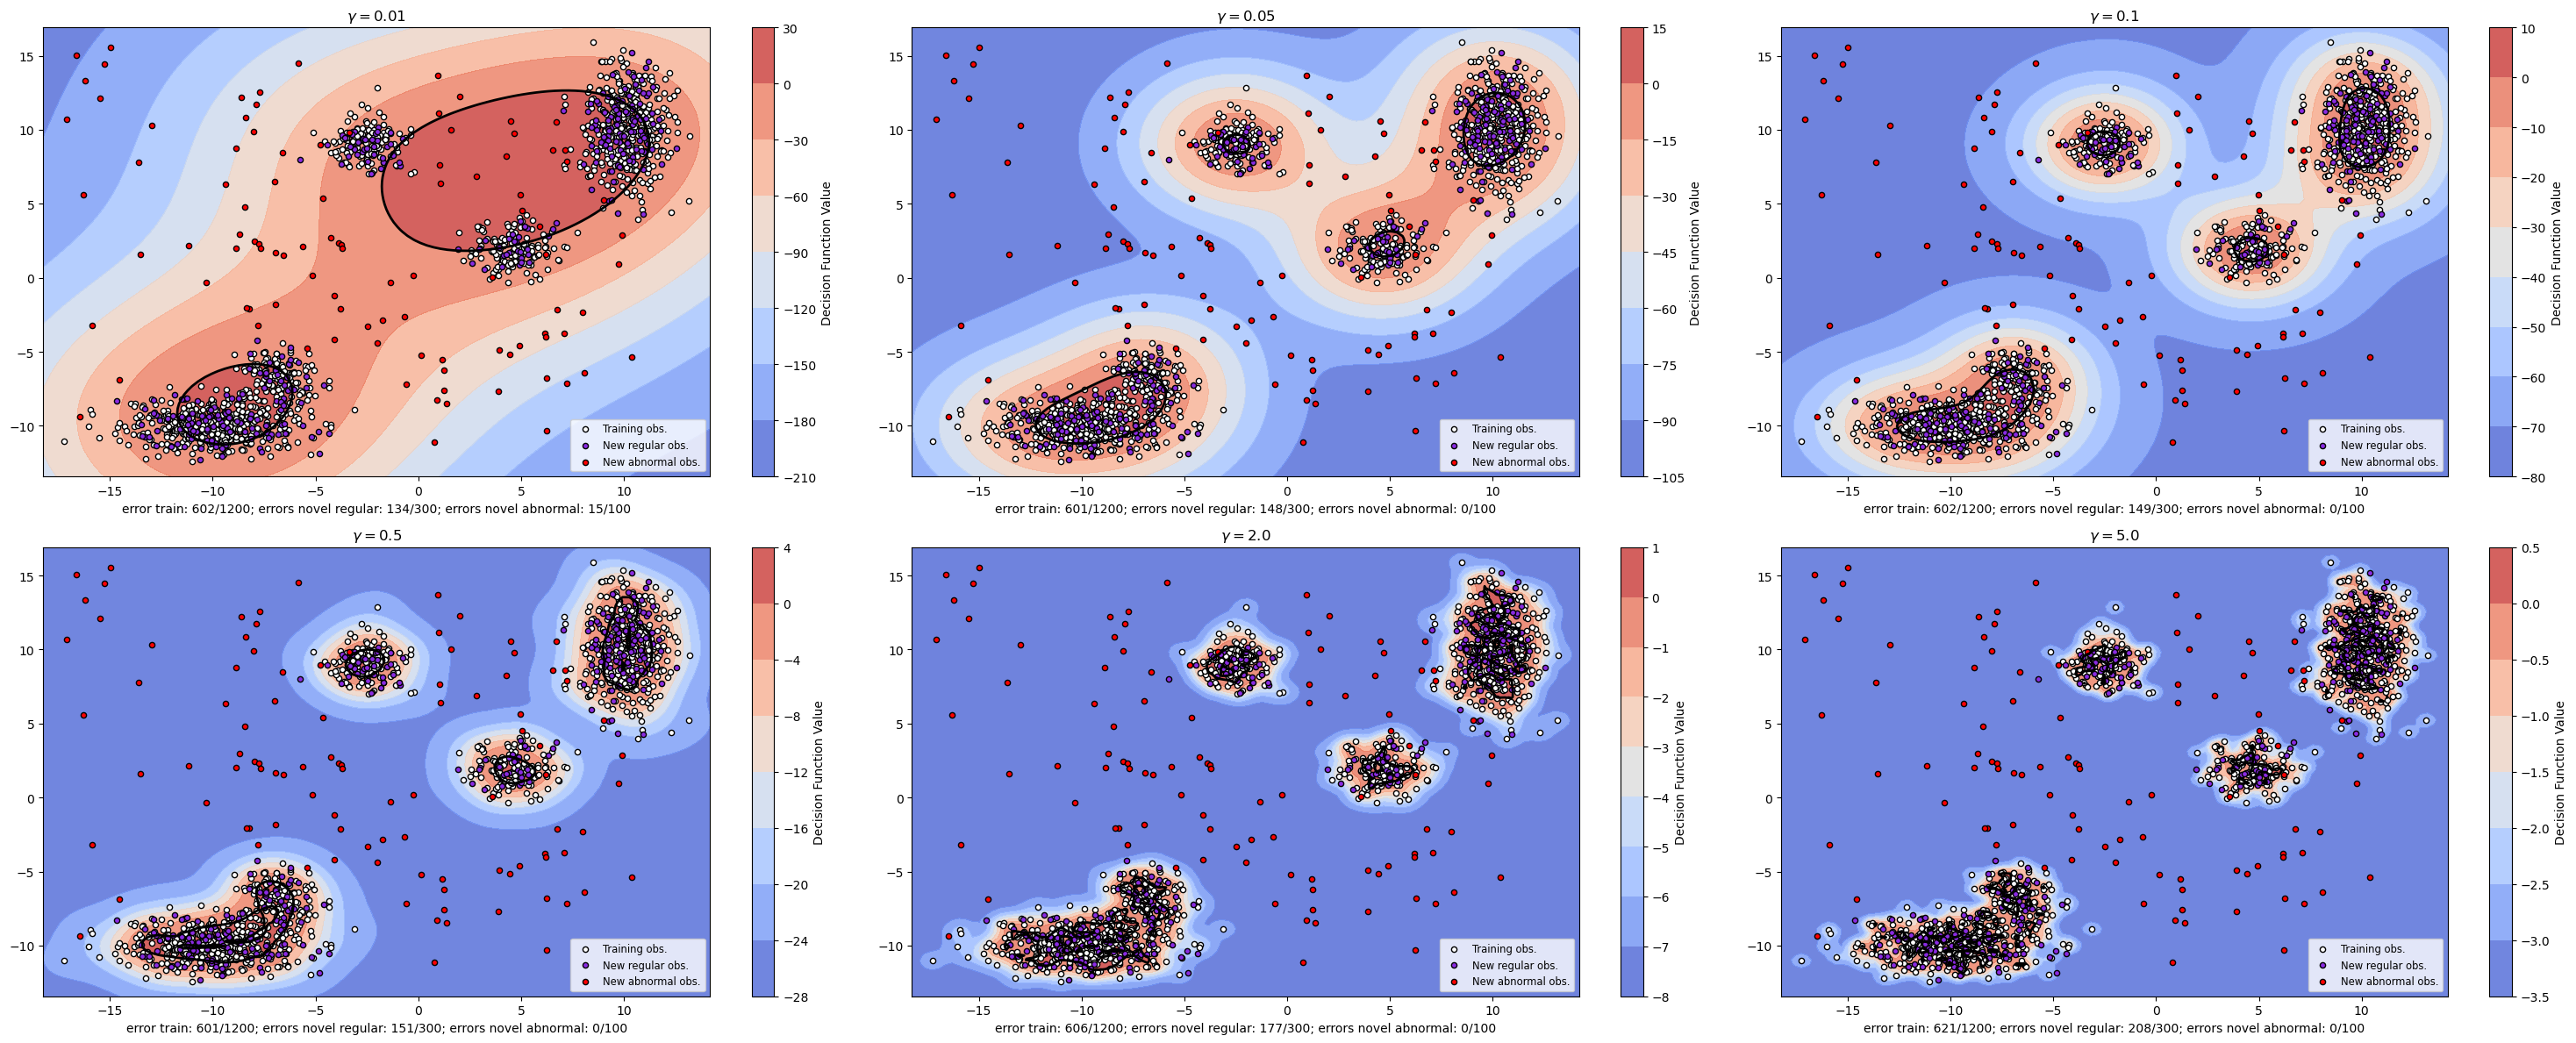

In [11]:
# Visualize decision boundaries for each model
fig, ax = plt.subplots(2, 3, figsize=(30, 12))
ax = ax.flatten()

for i, gamma in enumerate([0.01, 0.05, 0.1, 0.5, 2.0, 5.0]):
    svm_clf = train_one_class_svm(X_train, gamma=gamma)
    plot_decision_boundary_novelty(
        svm_clf, X_train, X_test, X_outliers, ax=ax[i], title=f"$\\gamma={gamma}$"
    )
fig.tight_layout()

Enfin, ce n'est pas le but de ce TME...


## Explications naïves


Mais pourquoi le classifieur prédit cette donnée comme exceptionnelle (ou non) ?

Pour expliquer cette prédiction, examinons d'abord les explications naïves que nous pouvons générer pour des classifieurs tels que LOF, SVM ou les arbres de décision lorsqu'ils évaluent une observation donnée, notée $x$, pour déterminer si elle est exceptionnelle ou non L'excplication mettra en évidence les modifications nécessaires pour que cette prédiction ne soit plus considérée comme une exception ou non.

Quelques pistes :

- LOF (Local Outlier Factor) : Lorsque le LOF attribue une valeur très élevée à une donnée, cela signifie qu'elle est très exceptionnelle. Nous devons donc nous demander si les modifications nécessaires pour expliquer cette prédiction sont plus importantes que celles nécessaires pour un LOF moyen. Existe-t-il une corrélation entre la valeur du LOF et l'ampleur des modifications suggérées par cette explication naïve ?

- Forêt d'isolation : Contrairement au LOF, la forêt d'isolation fonctionne selon un principe différent, ce qui signifie qu'il n'y a pas nécessairement de corrélation directe avec le LOF. Par conséquent, la raison sous-jacente à la prédiction d'exceptionnalité dans ce cas devrait différer de celle fournie par le LOF. Il peut être nécessaire d'utiliser des méthodes spécifiques pour les forêts, comme DIFFI (voir p.26).

Pour des explications plus sophistiquées, nous pouvons également considérer l'approche LIME, qui se penche sur les attributs importants dans la prise de décision du classifieur. Quels attributs sont déterminants pour que cette donnée soit considérée comme exceptionnelle par le modèle ?


### Growing Spheres

Meilleure algorithme pour produire des explications contrefactuelles dans notre situation, car on se rappelle que DiceML n'est pas adapté pour des modèles SKLearn.

In [12]:
class GrowingSpheres:
    """
    obs_to_interprete : x, une observation à interpréter
    clf : classifieur binaire
    eta : hyperparamètre
    n : nombre de points que l'on génère
    """

    def __init__(self, clf, eta, n):
        self.clf = clf
        self.eta = eta
        self.n = n

    def generate_spherical_layer(self, a0, a1) -> np.ndarray:
        """Generate a spherical layer with the specified parameters.

        :param a0: Inner radius of the spherical layer.
        :param a1: Outer radius of the spherical layer.
        :return: A numpy array representing the generated spherical layer.
        """

        def norm(v):
            return np.linalg.norm(v, ord=2, axis=1)

        z = np.random.normal(0, 1, (self.n, self.d))
        u = np.random.uniform(a0**self.d, a1**self.d, size=self.n)
        u = u ** (1 / self.d)
        z = np.array(
            [a * b / c for a, b, c in zip(z, u, norm(z))]
        )  # z = z * u / norm(z)
        return self.obs_to_interprete + z

    def find_enemy(self, spherical_layer):
        """Find and update enemy information in a spherical layer.

        :param spherical_layer: A 2D numpy array representing the spherical layer data.
        :return bool: True if enemies are found in the spherical layer, False otherwise.
        """
        pred = self.clf.predict(spherical_layer)
        self.enemies = spherical_layer[pred != self.obs_predict]
        return (pred != self.obs_predict).any()

    def predict(self, obs_to_interprete):
        self.obs_to_interprete = obs_to_interprete.reshape(1, -1)
        self.obs_predict = self.clf.predict(self.obs_to_interprete)
        self.d = self.obs_to_interprete.shape[1]

        enemy = self.generation()
        return enemy, self.feature_selection(enemy)

    def generation(self):
        self.iter = 0
        spherical_layer = self.generate_spherical_layer(0, 1)
        while self.find_enemy(spherical_layer):
            self.eta /= 2
            spherical_layer = self.generate_spherical_layer(0, self.eta)
            self.iter += 1
        a0 = self.eta
        a1 = 2 * self.eta
        while not self.find_enemy(spherical_layer):
            spherical_layer = self.generate_spherical_layer(a0, a1)
            a0 = a1
            a1 = a1 + self.eta
            self.iter += 1
        return self.enemies[
            np.linalg.norm(self.enemies - self.obs_to_interprete).argmin()
        ]

    def feature_selection(self, counterfactual):
        move_sorted = sorted(
            enumerate(abs(counterfactual - self.obs_to_interprete.flatten())),
            key=lambda x: x[1],
        )
        move_sorted = [x[0] for x in move_sorted if x[1] > 0.0]
        out = counterfactual.copy()
        reduced = 0

        for k in move_sorted:
            new_enn = out.copy()
            new_enn[k] = self.obs_to_interprete.flatten()[k]
            if self.clf.predict(new_enn.reshape(1, -1)) == self.obs_predict:
                out[k] = new_enn[k]
                reduced += 1
        return out


def find_enemies(fitted_clf, obs_to_interpret, n=10, eta=2, n_gs=100):
    enemies = []
    # enemies_fs = []
    for _ in range(n):
        gs = GrowingSpheres(fitted_clf, eta, n_gs)
        enemy, _ = gs.predict(obs_to_interpret)
        enemies.append(enemy)
        # enemies_fs.append(enemy_fs)
    return np.array(enemies)  # , enemies_fs


def visualize(
    X_train,
    X_test,
    X_outliers,
    fitted_clf,
    obs_to_interprete,
    n=10,
    eta=2,
    n_gs=100,
    ax=None,
):
    enemies = find_enemies(fitted_clf, obs_to_interprete, n, eta, n_gs)
    if not ax:
        _, ax = plt.subplots()
    plot_decision_boundary_novelty(
        fitted_clf, X_train, X_test, X_outliers, ax=ax, explain=True
    )
    ax.scatter(
        *obs_to_interprete, c="red", edgecolor="k", marker="o", label="Obs.", s=100
    )
    # ax.scatter(*enemy_fs, c="orange", marker="x", s=100)
    ax.scatter(
        enemies[:, 0],
        enemies[:, 1],
        c="lime",
        edgecolor="k",
        marker="*",
        label="Enemies",
        s=200,
    )
    bbox_args = dict(boxstyle="round", fc="0.8")
    arrow_args = dict(arrowstyle="->")
    xy = (obs_to_interprete[0], obs_to_interprete[1])
    xytext = (obs_to_interprete[0] + 5.0, obs_to_interprete[1])
    decision_value = fitted_clf.decision_function(obs_to_interprete.reshape(1, -1))
    predicted_value = fitted_clf.predict(obs_to_interprete.reshape(1, -1))
    ax.annotate(
        f"Décision: {decision_value[0]:.2f}\nPrédiction: {predicted_value[0]}",
        xy=xy,
        xytext=xytext,
        xycoords="data",
        textcoords="data",
        bbox=bbox_args,
        arrowprops=arrow_args,
    )
    # ax.scatter(*enemies_fs[-1], c="orange", marker="x", label="Enemy Feature Selection", s=100)
    ax.legend()
    return ax

#### LOF - Explications contrefactuelles


##### 3 distributions normales multidimensionnelles


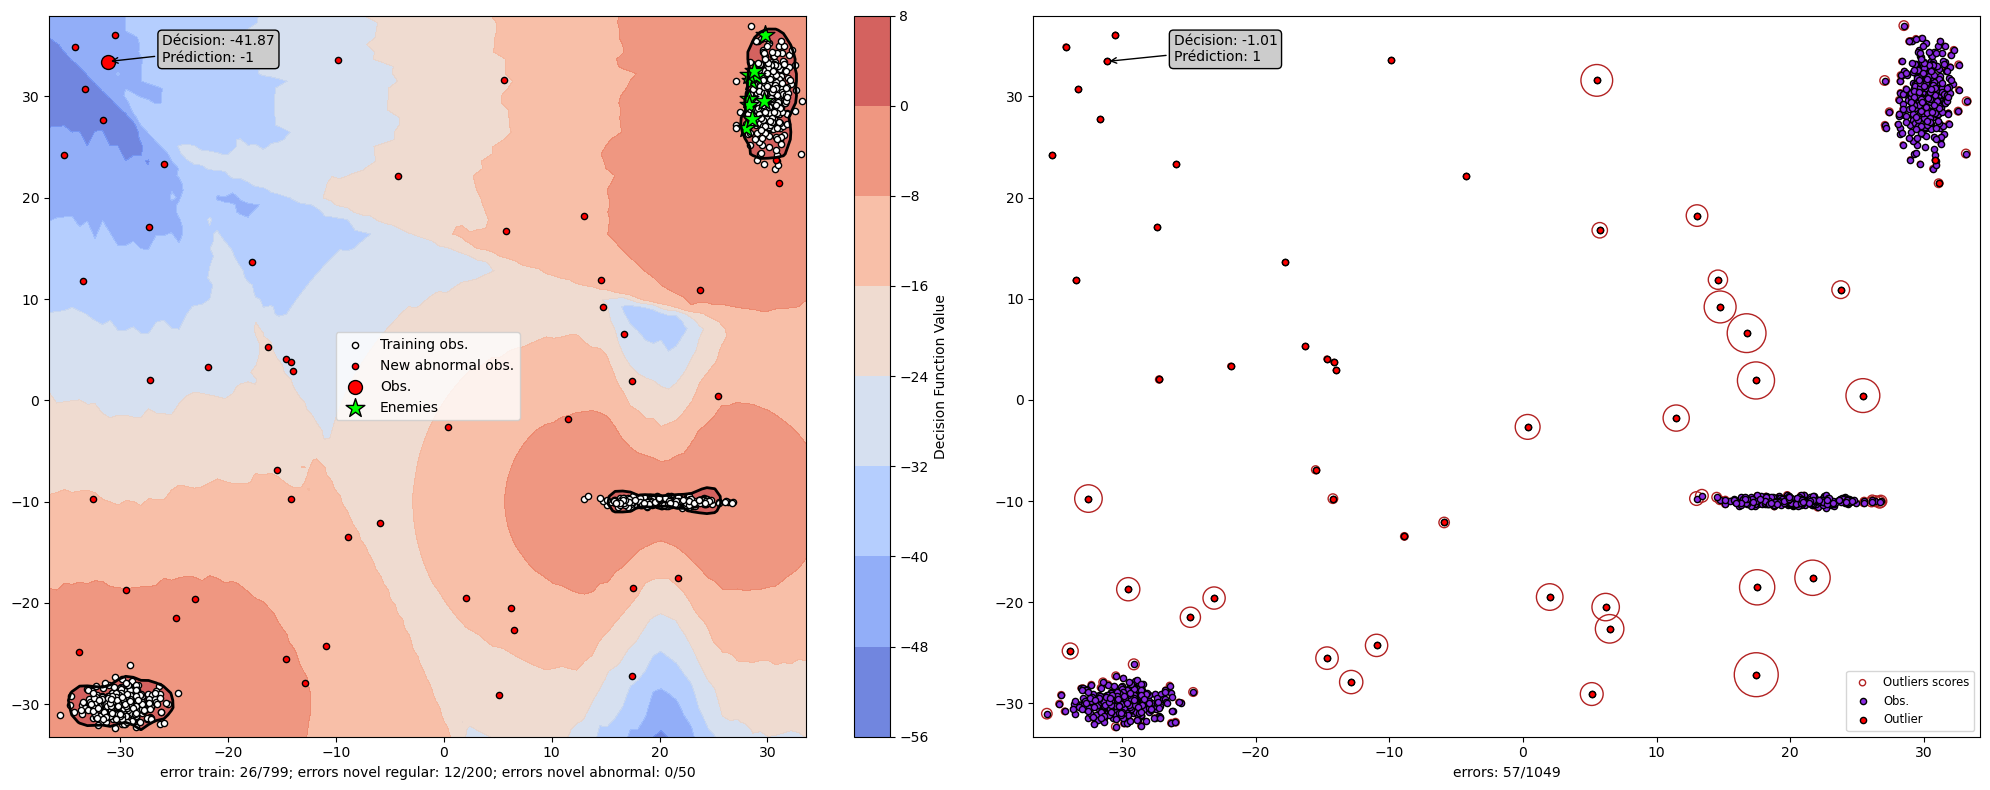

In [13]:
centers = [(-30, -30), (20, -10), (30, 30)]
cov = [
    np.array([[3, 0], [0, 1]]),
    np.array([[7, 0], [0, 0.05]]),
    np.array([[1, 0], [0, 7]]),
]
X_train, X_test, X_outliers = generate_elongated(n_clusters=3, centers=centers, cov=cov)
X = np.vstack((X_train, X_test, X_outliers))
lof_clf_outlier = train_lof(X, mode=False)
lof_clf_novelty = train_lof(X_train, mode=True)
y_pred = lof_clf_outlier.fit_predict(X)

idx = 16  # np.random.randint(X_outliers.shape[0])
obs = X_outliers[idx]

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
visualize(X_train, X_test, X_outliers, lof_clf_novelty, obs, ax=ax[0])

## Outlier detection
plot_decision_boundary_outlier(lof_clf_outlier, X, X_outliers, ax=ax[1])
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
xy = (obs[0], obs[1])
xytext = (obs[0] + 5.0, obs[1])
ax[1].annotate(
    f"Décision: {lof_clf_outlier.negative_outlier_factor_[idx]:.2f}\nPrédiction: {y_pred[idx]}",
    xy=xy,
    xytext=xytext,
    xycoords="data",
    textcoords="data",
    bbox=bbox_args,
    arrowprops=arrow_args,
)

fig.tight_layout()

D'où l'importance du mode de détection... Pourquoi LOF prédit une bonne partie des outliers de la partie gauche comme un grand cluster en mode "outlier" et pas en mode "novelty" ? :shrug:


Text(0, 0.5, 'Valeur de la fonction de décision')

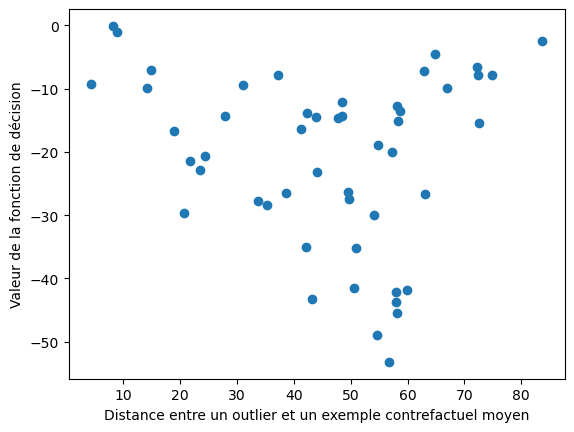

In [14]:
expl_outliers = []
for outlier in X_outliers:
    enemies = find_enemies(lof_clf_novelty, obs)
    avg_enemy = enemies.mean(0)
    expl_outliers.append(np.linalg.norm(outlier - avg_enemy))

plt.scatter(expl_outliers, lof_clf_novelty.decision_function(X_outliers))
plt.xlabel("Distance entre un outlier et un exemple contrefactuel moyen")
plt.ylabel("Valeur de la fonction de décision")

##### 2 distributions normales multidimensionnelles


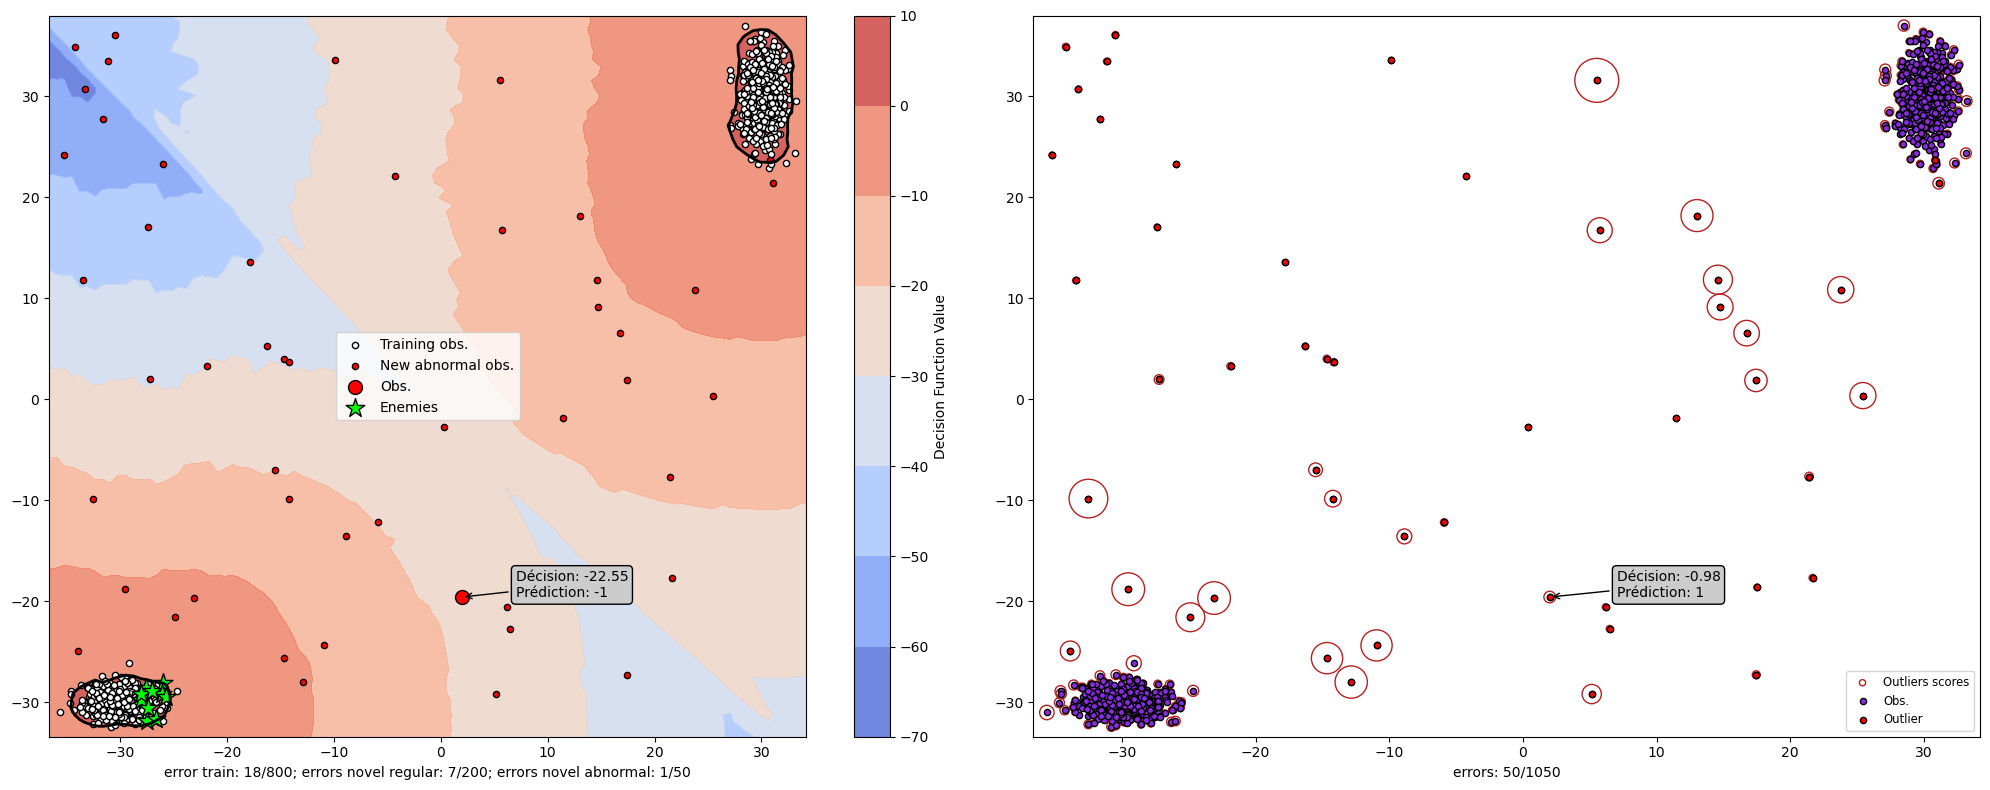

In [15]:
centers = [(-30, -30), (30, 30)]
cov = [np.array([[3, 0], [0, 1]]), np.array([[1, 0], [0, 7]])]
X_train, X_test, X_outliers = generate_elongated(n_clusters=2, centers=centers, cov=cov)
X = np.vstack((X_train, X_test, X_outliers))
lof_clf_outlier = train_lof(X, mode=False)
lof_clf_novelty = train_lof(X_train, mode=True)
y_pred = lof_clf_outlier.fit_predict(X)

idx = np.random.randint(X_outliers.shape[0])
obs = X_outliers[idx]

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
visualize(X_train, X_test, X_outliers, lof_clf_novelty, obs, ax=ax[0])

## Outlier detection
plot_decision_boundary_outlier(lof_clf_outlier, X, X_outliers, ax=ax[1])
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
xy = (obs[0], obs[1])
xytext = (obs[0] + 5.0, obs[1])
ax[1].annotate(
    f"Décision: {lof_clf_outlier.negative_outlier_factor_[idx]:.2f}\nPrédiction: {y_pred[idx]}",
    xy=xy,
    xytext=xytext,
    xycoords="data",
    textcoords="data",
    bbox=bbox_args,
    arrowprops=arrow_args,
)
fig.tight_layout()

Text(0, 0.5, 'Valeur de la fonction de décision')

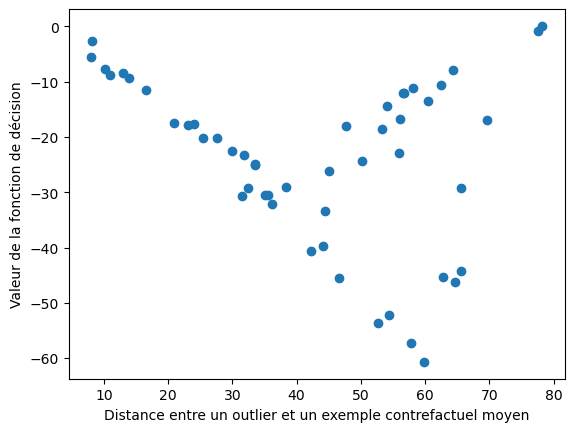

In [16]:
expl_outliers = []
for outlier in X_outliers:
    enemies = find_enemies(lof_clf_novelty, obs)
    avg_enemy = enemies.mean(0)
    expl_outliers.append(np.linalg.norm(outlier - avg_enemy))

plt.scatter(expl_outliers, lof_clf_novelty.decision_function(X_outliers))
plt.xlabel("Distance entre un outlier et un exemple contrefactuel moyen")
plt.ylabel("Valeur de la fonction de décision")

Visiblement, le LOF n'aime pas ce type de données (en mode "outlier detection")... Pourquoi ??


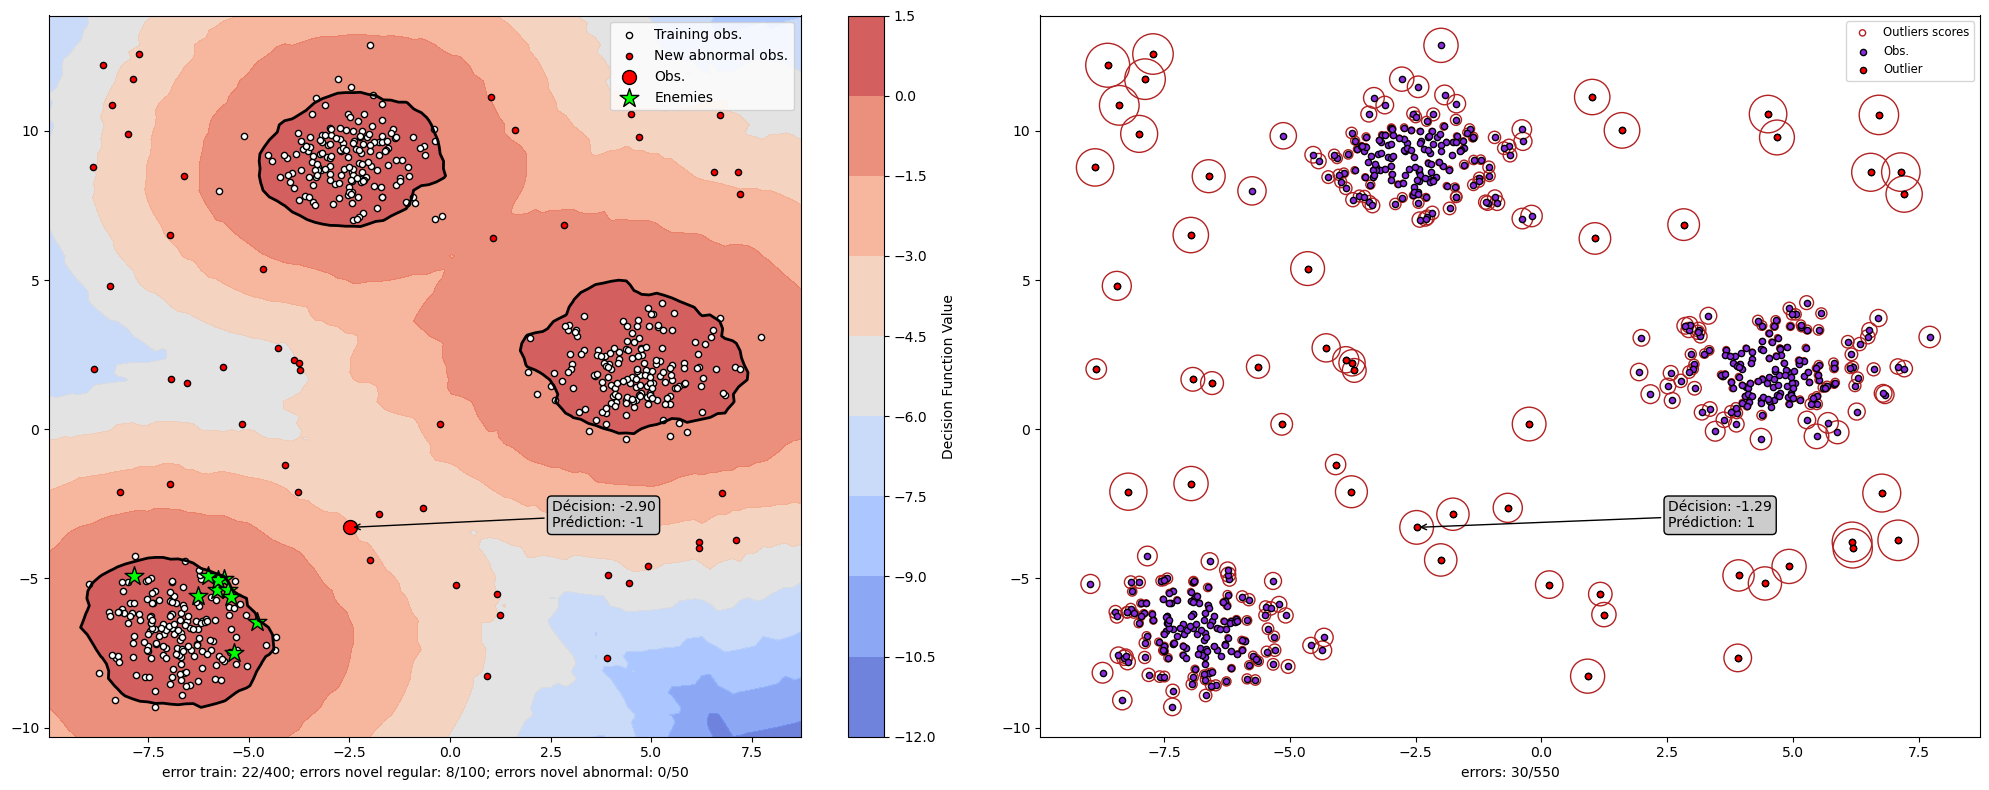

In [17]:
X_train, X_test, X_outliers = generate_blobs()
X = np.vstack((X_train, X_test, X_outliers))
lof_clf_outlier = train_lof(X, mode=False)
lof_clf_novelty = train_lof(X_train, mode=True)
y_pred = lof_clf_outlier.fit_predict(X)

idx = np.random.randint(X_outliers.shape[0])
obs = X_outliers[idx]

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
visualize(X_train, X_test, X_outliers, lof_clf_novelty, obs, ax=ax[0])

## Outlier detection
plot_decision_boundary_outlier(lof_clf_outlier, X, X_outliers, ax=ax[1])
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
xy = (obs[0], obs[1])
xytext = (obs[0] + 5.0, obs[1])
ax[1].annotate(
    f"Décision: {lof_clf_outlier.negative_outlier_factor_[idx]:.2f}\nPrédiction: {y_pred[idx]}",
    xy=xy,
    xytext=xytext,
    xycoords="data",
    textcoords="data",
    bbox=bbox_args,
    arrowprops=arrow_args,
)


fig.tight_layout()

Text(0.5, 1.0, 'Outlier detection')

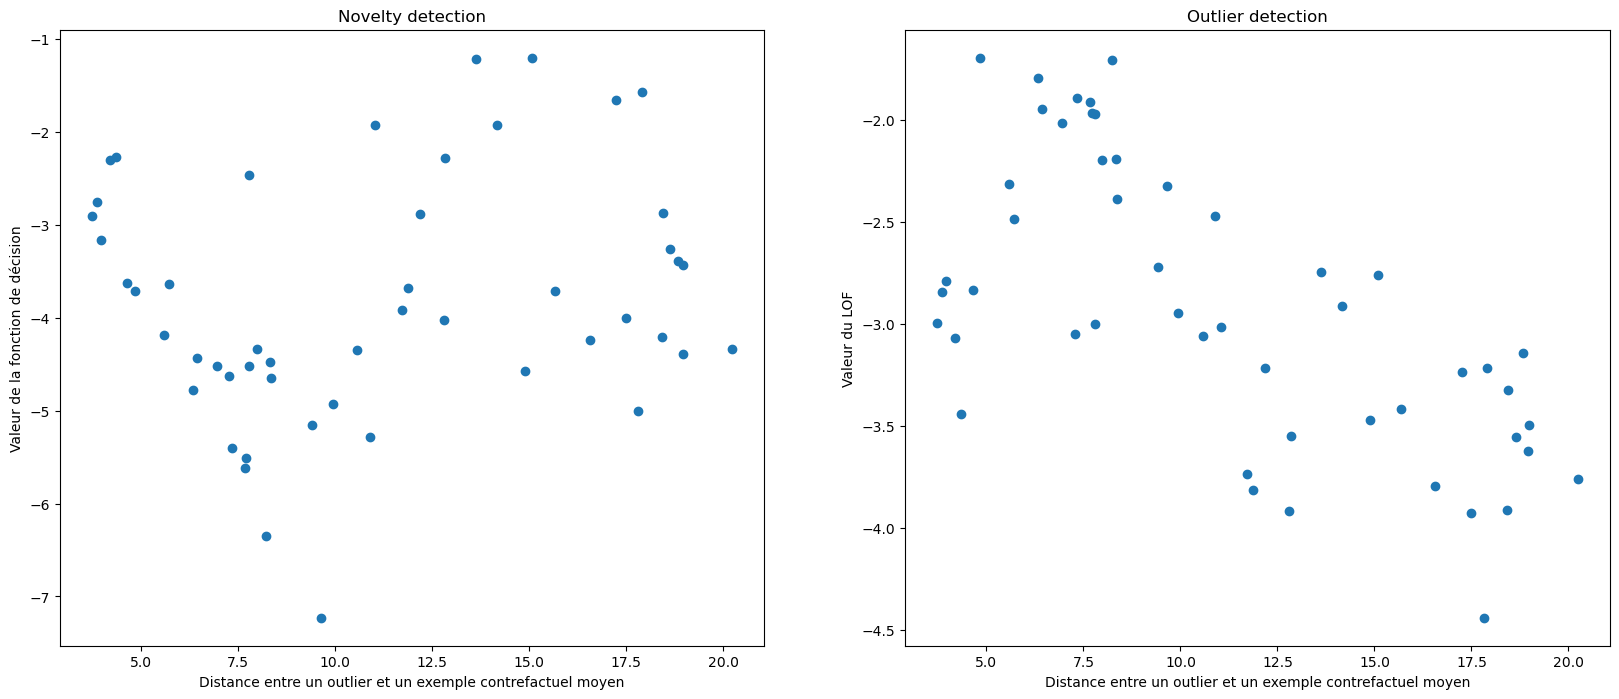

In [19]:
expl_outliers = []
for outlier in X_outliers:
    enemies = find_enemies(lof_clf_novelty, obs)
    avg_enemy = enemies.mean(0)
    expl_outliers.append(np.linalg.norm(outlier - avg_enemy))

plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.scatter(expl_outliers, lof_clf_novelty.decision_function(X_outliers))
plt.xlabel("Distance entre un outlier et un exemple contrefactuel moyen")
plt.ylabel("Valeur de la fonction de décision")
plt.title("Novelty detection")

plt.subplot(122)
plt.scatter(expl_outliers, lof_clf_outlier.negative_outlier_factor_[-len(X_outliers) :])
plt.xlabel("Distance entre un outlier et un exemple contrefactuel moyen")
plt.ylabel("Valeur du LOF")
plt.title("Outlier detection")

lol => pas forcément de corrélation entre distance entre outlier et distance avec contrefactuelle


#### One-Class SVM - Explications contrefactuelles


<Axes: xlabel='error train: 201/400; errors novel regular: 52/100; errors novel abnormal: 0/50'>

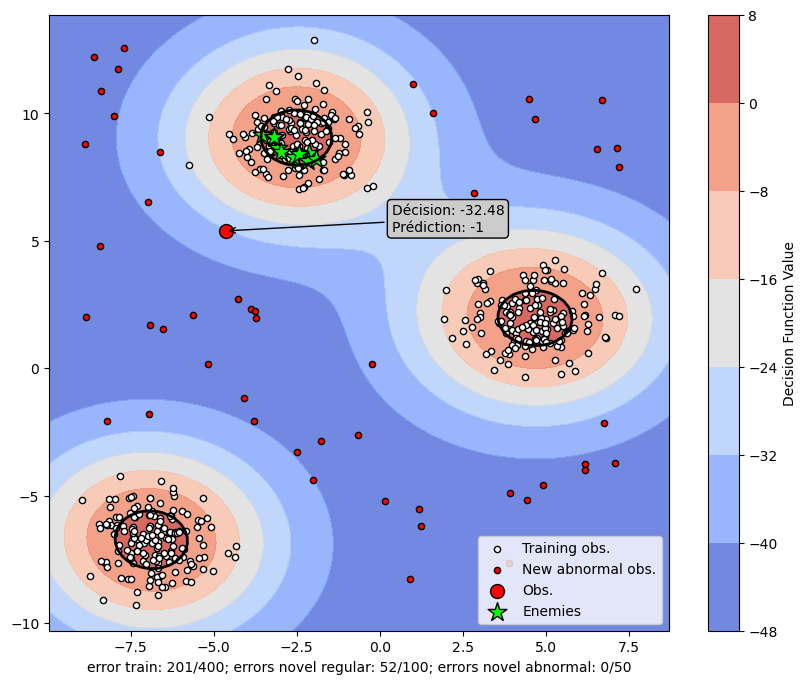

In [20]:
svm_clf = train_one_class_svm(X_train, gamma=0.1)
y_pred = svm_clf.predict(X_test)

idx = np.random.randint(X_outliers.shape[0])
obs = X_outliers[idx]

fig, ax = plt.subplots(figsize=(10, 8))
visualize(X_train, X_test, X_outliers, svm_clf, obs, ax=ax)

#### Isolation Forest - Explications contrefactuelles


<Axes: xlabel='error train: 108/400; errors novel regular: 31/100; errors novel abnormal: 0/50'>

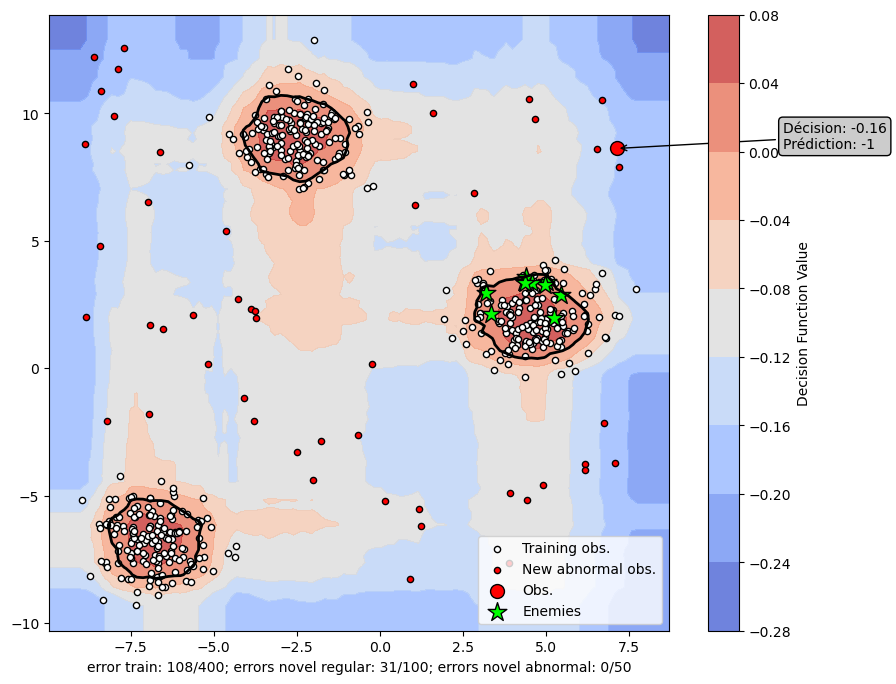

In [21]:
iso_forest_clf = train_isolation_forest(X_train)
y_pred = iso_forest_clf.predict(X_test)

idx = np.random.randint(X_outliers.shape[0])
obs = X_outliers[idx]

fig, ax = plt.subplots(figsize=(10, 8))
visualize(X_train, X_test, X_outliers, iso_forest_clf, obs, ax=ax)

### Importance d'attribut

p. 25-26 du cours : [LookOut](https://github.com/xuhongzuo/outlier-interpretation), [DIFFI](https://github.com/mattiacarletti/DIFFI), [KernelSHAP](https://github.com/ronniemi/explainAnomaliesUsingSHAP)...


## Explications moins naïves


là elle veut qu'on implémente quoi, son truc à elle, PANDA ??
